# Lomb-Scargle Example Dataset

## The Data

For simplicity, we download the data here and save locally

In [1]:
import pandas as pd

def get_LINEAR_lightcurve(lcid):
    from astroML.datasets import fetch_LINEAR_sample
    LINEAR_sample = fetch_LINEAR_sample()
    data = pd.DataFrame(LINEAR_sample[lcid],
                        columns=['t', 'mag', 'magerr'])
    data.to_csv('LINEAR_{0}.csv'.format(lcid), index=False)
  
# Uncomment to download the data
# get_LINEAR_lightcurve(lcid=11375941)

In [2]:
data = pd.read_csv('LINEAR_11375941.csv')
data.head()

,t,mag,magerr
0,52650.434545,15.969,0.035
1,52650.448450,16.036,0.039
2,52650.462420,15.990,0.035
3,52650.476485,16.027,0.035
4,52650.490443,15.675,0.030


In [3]:
data.shape

(280, 3)

In [4]:
(data.t.max() - data.t.min()) / 365.

5.3749242876712566

## Visualizing the Data

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-whitegrid')

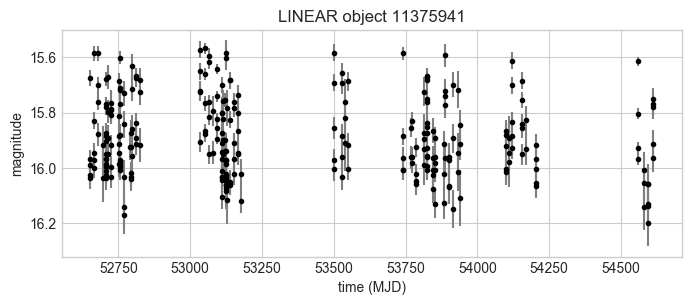

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(data.t, data.mag, data.magerr,
            fmt='.k', ecolor='gray', capsize=0)
ax.set(xlabel='time (MJD)',
       ylabel='magnitude',
       title='LINEAR object 11375941')
ax.invert_yaxis()

fig.savefig('fig01_LINEAR_data.pdf');

In [7]:
from astropy.stats import LombScargle
ls = LombScargle(data.t, data.mag, data.magerr)
frequency, power = ls.autopower(nyquist_factor=500,
                                minimum_frequency=0.2)

period_days = 1. / frequency
period_hours = period_days * 24

In [8]:
best_period = period_days[np.argmax(power)]

phase = (data.t / best_period) % 1

print("Best period: {0:.2f} hours".format(24 * best_period))

Best period: 2.58 hours


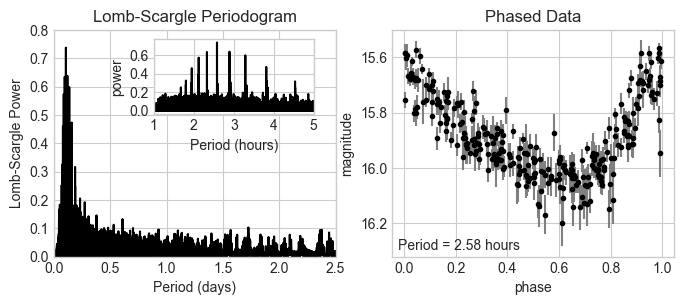

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# PSD has a _LOT_ of elements. Rasterize it so it can be displayed as PDF
ax[0].plot(period_days, power, '-k', rasterized=True)

ax[0].set(xlim=(0, 2.5), ylim=(0, 0.8),
          xlabel='Period (days)',
          ylabel='Lomb-Scargle Power',
          title='Lomb-Scargle Periodogram')

ax[1].errorbar(phase, data.mag, data.magerr,
               fmt='.k', ecolor='gray', capsize=0)
ax[1].set(xlabel='phase',
          ylabel='magnitude',
          title='Phased Data')
ax[1].invert_yaxis()
ax[1].text(0.02, 0.03, "Period = {0:.2f} hours".format(24 * best_period),
           transform=ax[1].transAxes)

inset = fig.add_axes([0.25, 0.6, 0.2, 0.25])
inset.plot(period_hours, power, '-k', rasterized=True)
inset.xaxis.set_major_locator(plt.MultipleLocator(1))
inset.yaxis.set_major_locator(plt.MultipleLocator(0.2))
inset.set(xlim=(1, 5),
          xlabel='Period (hours)',
          ylabel='power')

fig.savefig('fig02_LINEAR_PSD.pdf');

## Peak Precision

Estimate peak precision by plotting the Bayesian periodogram peak and fitting a Gaussian to the peak (for simplicity, just do it by-eye):

/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp
/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


(2.58, 2.5803)

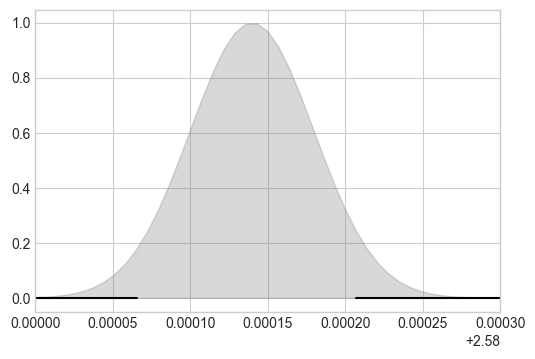

In [10]:
f, P = ls.autopower(nyquist_factor=500,
                    minimum_frequency=9.3,
                    maximum_frequency=9.31,
                    samples_per_peak=20,
                    normalization='psd')
P = np.exp(P)
P /= P.max()
h = 24. / f

plt.plot(h, P, '-k')
plt.fill(h, np.exp(-0.5 * (h - 2.58014) ** 2 / 0.00004 ** 2), color='gray', alpha=0.3)
plt.xlim(2.58, 2.5803)

Looks like $2.58023 \pm 0.00006$ hours

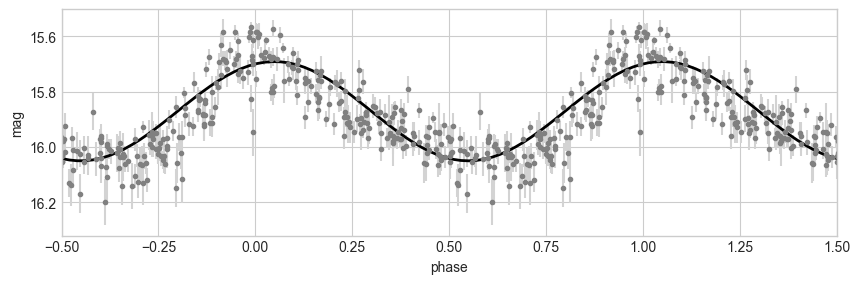

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))

phase_model = np.linspace(-0.5, 1.5, 100)
best_frequency = frequency[np.argmax(power)]
mag_model = ls.model(phase_model / best_frequency, best_frequency)

for offset in [-1, 0, 1]:
    ax.errorbar(phase + offset, data.mag, data.magerr, fmt='.',
                color='gray', ecolor='lightgray', capsize=0);
ax.plot(phase_model, mag_model, '-k', lw=2)
ax.set(xlim=(-0.5, 1.5),
       xlabel='phase',
       ylabel='mag')
ax.invert_yaxis()

fig.savefig('fig18_ls_model.pdf')

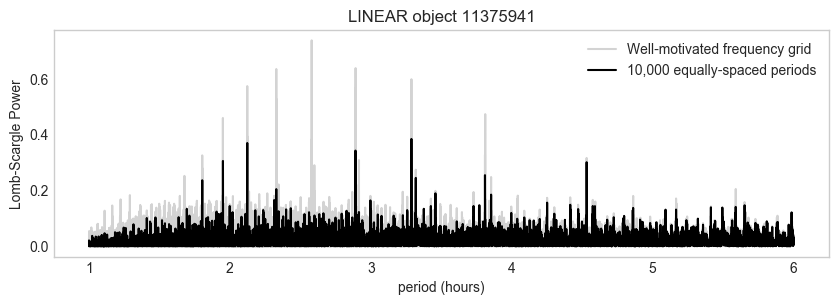

In [12]:
period_hours_bad = np.linspace(1, 6, 10001)
frequency_bad = 24 / period_hours_bad
power_bad = ls.power(frequency_bad)

mask = (period_hours > 1) & (period_hours < 6)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(period_hours[mask], power[mask], '-', color='lightgray',
        rasterized=True, label='Well-motivated frequency grid')
ax.plot(period_hours_bad, power_bad, '-k',
        rasterized=True, label='10,000 equally-spaced periods')
ax.grid(False)
ax.legend()
ax.set(xlabel='period (hours)',
       ylabel='Lomb-Scargle Power',
       title='LINEAR object 11375941')

fig.savefig('fig19_LINEAR_coarse_grid.pdf')

## Required Grid Spacing

In [13]:
!head LINEAR_11375941.csv

t,mag,magerr
52650.434545,15.969,0.035
52650.44845,16.036,0.039
52650.46242,15.99,0.035
52650.476485,16.027,0.035
52650.490443,15.675,0.03
52666.464263,15.945,0.037
52666.478719,15.97,0.035
52666.493183,16.001,0.035
52666.50771,15.829,0.031


In [14]:
n_digits = 6
f_ny = 0.5 * 10 ** n_digits
T = (data.t.max() - data.t.min())
n_o = 5

delta_f = 1. / n_o / T

print("f_ny =", f_ny)
print("T =", T)
print("n_grid =", f_ny / delta_f)

f_ny = 500000.0
T = 1961.847365
n_grid = 4904618412.5
